In [130]:
import numpy as np
import pandas as pd
import yahoofinancials as yf
import matplotlib.pyplot as plt
import matplotlib as mpl
import math as mt
from scipy.stats import skew, skewtest, norm, kurtosis, kurtosistest, normaltest
from matplotlib.pyplot import figure

In [131]:
mpl.rcParams['font.family'] = 'serif'

In [132]:
ticker = input("Escolha o ticker da ação segundo o Yahoo Financials: ")

datainicio = input("Escolha a data inicial dos dados no formato yyyy-mm-dd: ")
datafinal =  input("Escolha a data final dos dados no formato yyyy-mm-dd: ")

Escolha o ticker da ação segundo o Yahoo Financials: ABEV3.SA
Escolha a data inicial dos dados no formato yyyy-mm-dd: 2010-04-19
Escolha a data final dos dados no formato yyyy-mm-dd: 2022-04-19


In [133]:
data = yf.YahooFinancials(ticker).get_historical_price_data(datainicio, datafinal, 'daily')

In [134]:
# Ler os dados do JSON
raw = pd.DataFrame(data[ticker]['prices']).dropna()
# Converter a data para o tipo correto datetime
raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
# Indica a data como o índice de cada linha
raw = raw.set_index('formatted_date')
# Removendo as colunas que não interessam
df = raw.iloc[:,1:]

# Acertando a ordem das colunas
df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
# Salvando o CSV
df.to_csv('{}.csv'.format(ticker))

_____________________

In [135]:
del df['open']
del df['volume']
del df['high']
del df['low']
del df['close']

In [136]:
df['pct_change'] = df['adjclose'].pct_change()

In [137]:
df['log_return'] = np.log1p(df.adjclose.pct_change())

________________

Rolling mean log returns:

In [138]:
rolling_windows = df.log_return.rolling(2, min_periods=1)
rolling_mean = rolling_windows.mean()

________________

In [139]:
meanlogr = df.log_return.mean()
print(meanlogr)

dailystdlogr = df.log_return.std()
print(dailystdlogr)

0.0004505505491318372
0.0168207977034482


___________________

In [140]:
D = len(df.log_return) 

annualmeanlogr = (1+df.log_return.sum()) ** (252/D) - 1
print(annualmeanlogr)

0.07464968054919607


______________________

In [141]:
annualstdlogr = dailystdlogr * mt.sqrt(252)
print(annualstdlogr)

0.267021885462302


_________________

### Skew

In [142]:
skewofsample = skew(df.log_return.dropna())

ptestskew = skewtest(df.log_return.dropna())
skewpvalue = ptestskew.pvalue
print(skewpvalue)
print(skewofsample)

7.652824757398427e-12
-0.3137770318206983


### Kurt

In [143]:
kurtosisvalue = kurtosis(df.log_return.dropna())

kurtosistest = kurtosistest(df.log_return.dropna())
kurtosispvalue = kurtosistest.pvalue
print(kurtosispvalue)

5.291169558320016e-106


### Normal Test

In [144]:
normaltest = normaltest(df.log_return.dropna())
normalpvalue = normaltest.pvalue
print(normalpvalue)

9.736089607257743e-115


### Realized Volatily and Realized Variance

In [145]:
window = 252
trd_days = 252
ann_factor = window/trd_days

rlz_var = df['log_return'].rolling(window).var() * ann_factor
rlz_vol = np.sqrt(rlz_var)

___________________

### Gráficos a serem utilizados:

In [146]:
df['rolling_mean'] = rolling_mean
df['rlz_vol'] = rlz_vol
rolling_correlation = df['rolling_mean'].rolling(252).corr(df['rlz_vol'])

## Table final

In [147]:
print("Mean of Daily Log Returns: ", round(meanlogr,5))
print("Std of Daily Log Returns: ", round(dailystdlogr, 5))
print("Mean of Annual Log Returns: ", round(annualmeanlogr, 5))
print("Std of Annual Log Returns: ", round(annualstdlogr,5))
print("")
print("Skew of Sample Log Returns: ", round(skewofsample, 5))
print("Skew Normal Test p-value: ", skewpvalue)
print("")
print("Kurt of Sample Log Returns: ", round(kurtosisvalue,5))
print("Kurt Normal Test p-value: ", kurtosispvalue)
print("")
print("Normal Test p-value: ", normalpvalue)

Mean of Daily Log Returns:  0.00045
Std of Daily Log Returns:  0.01682
Mean of Annual Log Returns:  0.07465
Std of Annual Log Returns:  0.26702

Skew pf Sample Log Returns:  -0.31378
Skew Normal Test p-value:  7.652824757398427e-12

Kurt of Sample Log Returns:  8.42453
Kurt Normal Test p-value:  5.291169558320016e-106

Normal Test p-value:  9.736089607257743e-115


In [148]:
%config InlineBackend.figure_format = 'svg'

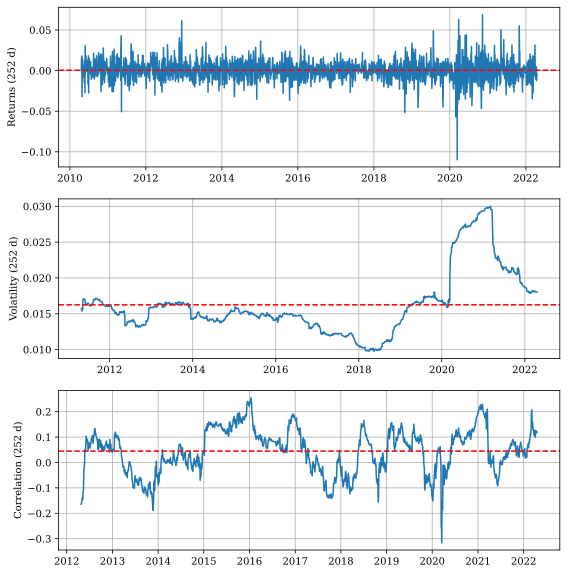

<Figure size 720x720 with 0 Axes>

In [149]:
fig, axs = plt.subplots(3, figsize=(9, 10))
plt.figure(figsize=(10,10))

axs[0].plot(rolling_mean)
axs[0].set(ylabel = "Returns (252 d)")
l0=axs[0].axhline(rolling_mean.mean(),color='red',ls='--')
axs[0].grid(visible = True)

axs[1].plot(rlz_vol)
axs[1].set(ylabel = "Volatility (252 d)")
l1=axs[1].axhline(rlz_vol.mean(),color='red',ls='--')
axs[1].grid(visible = True)

axs[2].plot(rolling_correlation)
axs[2].set(ylabel = "Correlation (252 d)")
l2=axs[2].axhline(rolling_correlation.mean(),color='red',ls='--')
axs[2].grid(visible = True)